In [1]:
import pandas as pd
import csv
import os
import numpy as np

In [34]:
csv_path = os.path.join('Data_Feature_Names.csv')
cc_df = pd.read_csv(csv_path)
cc_df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [40]:
df = pd.read_excel('Data_Feature_Names.xls', header=1)

In [50]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month', 'target'],
      dtype='object')

In [51]:
print("Explanatory variables: {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))

Explanatory variables: 24
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


## Attributes description

defaulting accounts are 22.12% out of 30000 observations


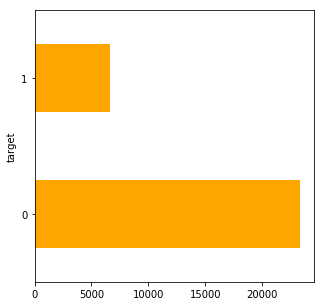

In [52]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

In [54]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [55]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

### Absolute statistics

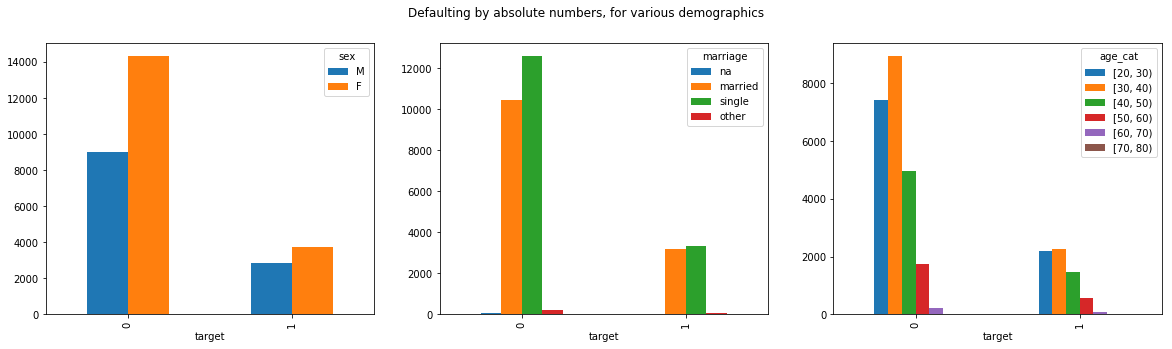

In [56]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

### Statistics Relative to the Population

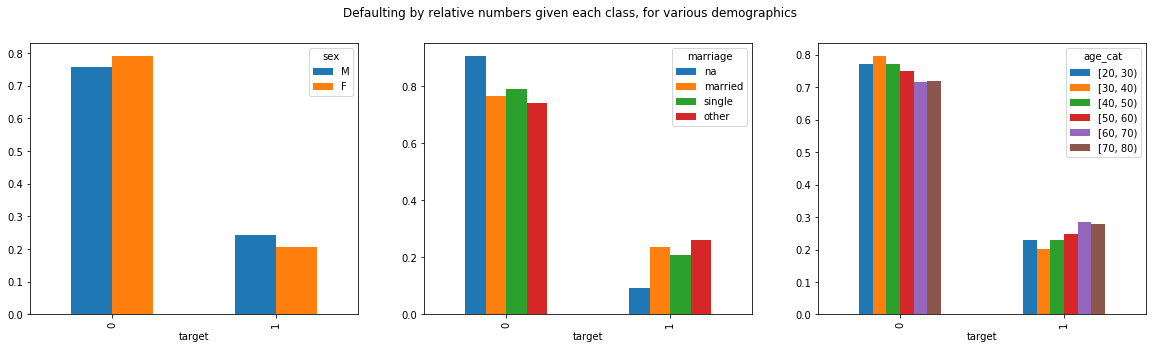

In [57]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

### Feature Engineering

#### It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that payment they exibits a log/log distribution, so first off, we are going to take the log of the payments.

In [58]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [59]:
from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [60]:
# average payment# averag 
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [61]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']

In [62]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

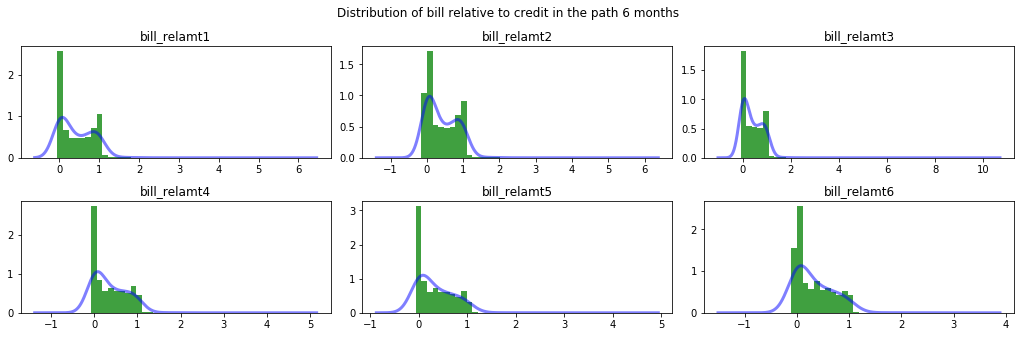

In [64]:
import re

from sklearn.neighbors.kde import KernelDensity

pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of bill relative to credit in the path 6 months')

for i in range(len(columns)):
    row,col = int(i/3), i%3

    d = df[columns[i]]
    # the histogram of the data
    n, bins, patches = ax[row,col].hist(d, 50, normed=1, facecolor='green', alpha=0.75)

    # kernel density estimation
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
    x_grid = np.linspace(d.min(), d.max(), 1000)
    log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

    # add the density line
    ax[row,col].plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)
    ax[row,col].set_title(columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

### Intuition: If the credit limit is much larger than the bill, being behind might not be a problem. Therefore this contructed feature might turn-up useful when predicting defaulting.

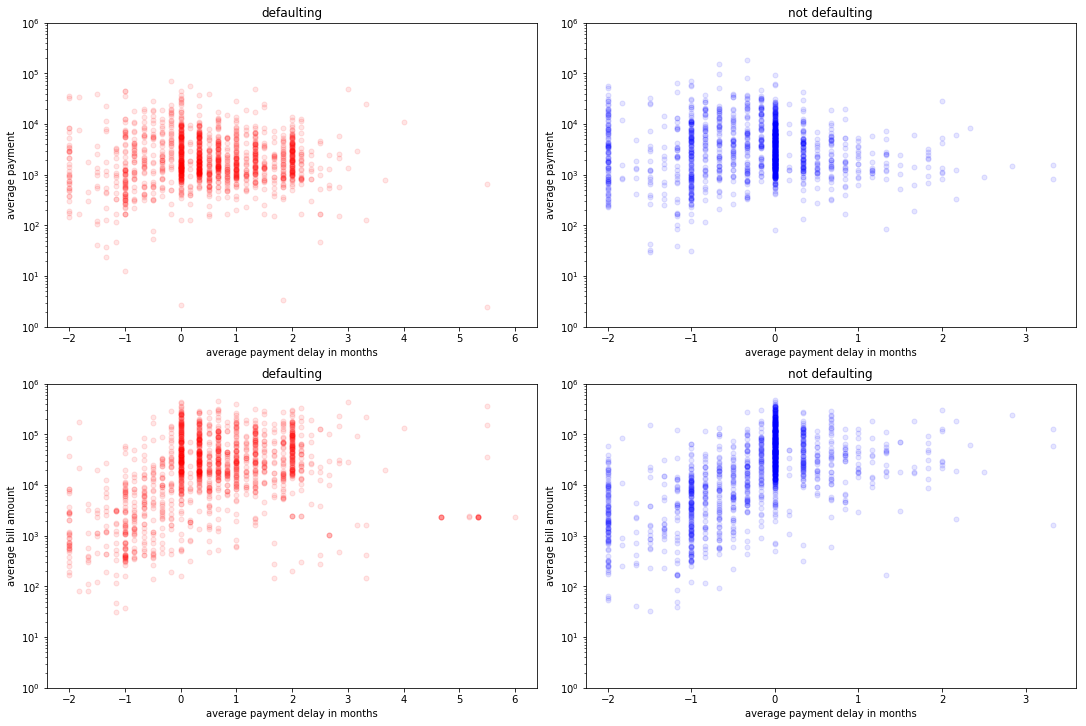

In [67]:
def_no = df[df['target']==0].sample(1500)
def_yes  = df[df['target']==1].sample(1500)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

ax[0,0].set_ylim([1,1e6])
ax[0,0].set_title('defaulting')
ax[0,0].set_ylabel('average payment')
ax[0,0].set_xlabel('average payment delay in months')
p = ax[0,0].semilogy(def_yes['pay_avg'], def_yes['pay_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[0,1].set_ylim([1,1e6])
ax[0,1].set_title('not defaulting')
ax[0,1].set_ylabel('average payment')
ax[0,1].set_xlabel('average payment delay in months')
p = ax[0,1].semilogy(def_no['pay_avg'], def_no['pay_amt_avg'], 'bo', markersize=5, alpha=0.1)

ax[1,0].set_ylim([1,1e6])
ax[1,0].set_title('defaulting')
ax[1,0].set_ylabel('average bill amount')
ax[1,0].set_xlabel('average payment delay in months')
p = ax[1,0].semilogy(def_yes['pay_avg'], def_yes['bill_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[1,1].set_ylim([1,1e6])
ax[1,1].set_title('not defaulting')
ax[1,1].set_ylabel('average bill amount')
ax[1,1].set_xlabel('average payment delay in months')
p = ax[1,1].semilogy(def_no['pay_avg'], def_no['bill_amt_avg'], 'bo', markersize=5, alpha=0.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### From variables to train, test matrices

In [72]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

### Visualization: Confusion matrices and AUC curves

In [74]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

### Feature Selection

In [88]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 23)
selector.fit(X, y)

SelectKBest(k=23, score_func=<function f_classif at 0x110b5e1e0>)

In [76]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-23:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1', 'pay_avg', 'pay_2', 'pay_3', 'pay_std', 'pay_4', 'pay_5',
       'pay_6', 'limit_bal_log', 'pay_amt_log1', 'pay_amt_avg_log',
       'bill_relamt6', 'bill_relamt5', 'bill_relamt4', 'pay_amt_log2',
       'bill_relamt3', 'bill_relamt2', 'pay_amt_log3', 'bill_relamt1',
       'pay_amt_log4', 'pay_amt_log6', 'pay_amt_log5',
       'C(limit_bal_cat)[T.Interval(20000, 30000, closed='left')]'],
      dtype='object')

### Feature Scaling

In [89]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [90]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

### Model Selection and Validation

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

In [81]:
from  sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

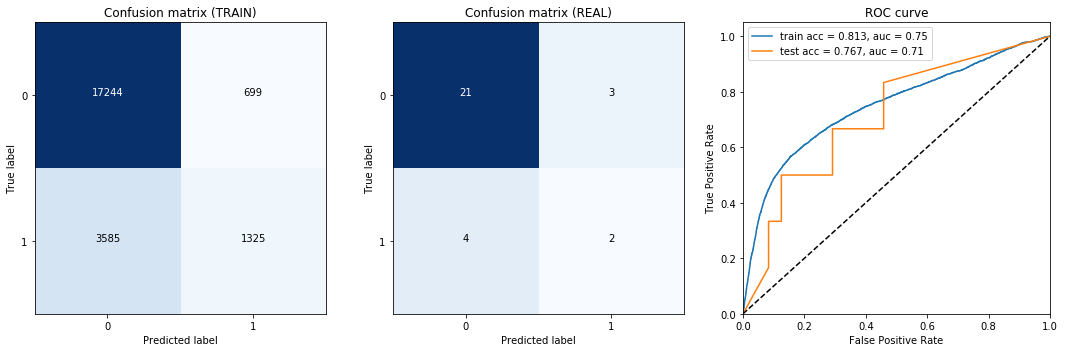

In [117]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_real_pred = regr.predict_proba(X_Real)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_Real, y_real_pred,   [0,1], 'Confusion matrix (REAL)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_Real, y_real_pred, threshold)
    
plt.tight_layout()
plt.show()

In [120]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

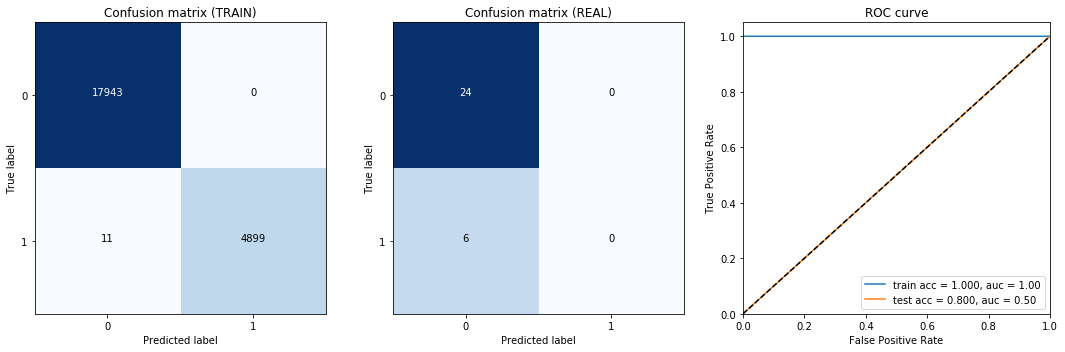

In [121]:
y_train_pred = dtree.predict_proba(X_train)[:,1]
y_real_pred = dtree.predict_proba(X_Real)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_Real, y_real_pred,   [0,1], 'Confusion matrix (REAL)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_Real, y_real_pred, threshold)
    
plt.tight_layout()
plt.show()

## SVM

In [83]:
from sklearn.svm import SVC 

model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [3]:
cc_df = cc_df.drop([0])

In [4]:
len(cc_df)

30000

In [5]:
cc_df.isnull().sum()

Unnamed: 0    0
X1            0
X2            0
X3            0
X4            0
X5            0
X6            0
X7            0
X8            0
X9            0
X10           0
X11           0
X12           0
X13           0
X14           0
X15           0
X16           0
X17           0
X18           0
X19           0
X20           0
X21           0
X22           0
X23           0
Y             0
dtype: int64

In [6]:
X = np.column_stack((cc_df.X1,cc_df.X2,cc_df.X3,cc_df.X4,cc_df.X5,cc_df.X6,cc_df.X7,cc_df.X8,cc_df.X9,cc_df.X10,cc_df.X11,cc_df.X12,cc_df.X13,cc_df.X14,cc_df.X15,cc_df.X16,cc_df.X17,cc_df.X18,cc_df.X19,cc_df.X20,cc_df.X21,cc_df.X22,cc_df.X23))
# X = np.column_stack((cc_df.X2,cc_df.X3,cc_df.X4,cc_df.X5,cc_df.X6,cc_df.X7,cc_df.X8,cc_df.X9,cc_df.X10,cc_df.X11))
X

array([['20000', '2', '2', ..., '0', '0', '0'],
       ['120000', '2', '2', ..., '1000', '0', '2000'],
       ['90000', '2', '2', ..., '1000', '1000', '5000'],
       ...,
       ['30000', '1', '2', ..., '4200', '2000', '3100'],
       ['80000', '1', '3', ..., '1926', '52964', '1804'],
       ['50000', '1', '2', ..., '1000', '1000', '1000']], dtype=object)

In [7]:
y  = np.array((cc_df.Y))
y

array(['1', '1', '0', ..., '1', '1', '1'], dtype=object)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Testing Data Score: 0.7785333333333333


## 'Logistic Regression' Predictions with Real Data

In [111]:
real_csv_path = os.path.join('Real_Data_Sheet.csv')
real_cc_df = pd.read_csv(real_csv_path)
real_cc_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,5500,1,2,1,33,-1,-1,-1,-1,-1,...,482,112,252,417,570,987,482,112,252,0
1,10000,1,2,1,33,9,9,9,8,7,...,5000,8700,8900,800,3000,200,1000,3700,200,0
2,5400,1,2,1,33,8,7,6,5,4,...,4382,3792,3367,2000,200,200,200,100,100,0
3,15000,1,2,1,32,9,9,8,7,6,...,2759,2900,3100,1800,700,100,159,500,200,0
4,2050,1,2,1,31,-1,-1,-1,-1,-1,...,294,14,88,132,126,352,294,14,88,1
5,7500,1,2,1,31,-1,7,6,5,4,...,3180,1150,688,1269,1200,839,795,25,25,0
6,13000,1,2,1,32,9,8,7,6,5,...,7606,7682,9682,1258,1400,230,176,76,2000,0
7,5500,1,2,1,31,9,8,7,6,5,...,1482,1607,305,319,278,450,132,125,305,0
8,6000,1,2,1,31,9,8,7,6,5,...,1311,442,818,516,26,239,1000,25,1818,0
9,3500,1,2,1,31,9,8,7,6,5,...,555,620,575,200,250,300,350,400,450,1


In [112]:
real_cc_df.isnull().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
y      0
dtype: int64

In [113]:
X_Real = np.column_stack((real_cc_df.X1,real_cc_df.X2,real_cc_df.X3,real_cc_df.X4,real_cc_df.X5,real_cc_df.X6,real_cc_df.X7,real_cc_df.X8,real_cc_df.X9,real_cc_df.X10,real_cc_df.X11,real_cc_df.X12,real_cc_df.X13,real_cc_df.X14,real_cc_df.X15,real_cc_df.X16,real_cc_df.X17,real_cc_df.X18,real_cc_df.X19,real_cc_df.X20,real_cc_df.X21,real_cc_df.X22,real_cc_df.X23))
# X = np.column_stack((cc_df.X2,cc_df.X3,cc_df.X4,cc_df.X5,cc_df.X6,cc_df.X7,cc_df.X8,cc_df.X9,cc_df.X10,cc_df.X11))
X_Real

array([[ 5500,     1,     2,     1,    33,    -1,    -1,    -1,    -1,
           -1,    -1,   417,   570,   987,   482,   112,   252,   417,
          570,   987,   482,   112,   252],
       [10000,     1,     2,     1,    33,     9,     9,     9,     8,
            7,     6,   800,  3800,  4000,  5000,  8700,  8900,   800,
         3000,   200,  1000,  3700,   200],
       [ 5400,     1,     2,     1,    33,     8,     7,     6,     5,
            4,     3,  3393,  4828,  4751,  4382,  3792,  3367,  2000,
          200,   200,   200,   100,   100],
       [15000,     1,     2,     1,    32,     9,     9,     8,     7,
            6,     5,  1800,  2500,  2600,  2759,  2900,  3100,  1800,
          700,   100,   159,   500,   200],
       [ 2050,     1,     2,     1,    31,    -1,    -1,    -1,    -1,
           -1,    -1,   132,   126,   352,   294,    14,    88,   132,
          126,   352,   294,    14,    88],
       [ 7500,     1,     2,     1,    31,    -1,     7,     6,     5,

In [114]:
y_Real  = np.array((real_cc_df.y))
y_Real

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1])

In [115]:
classifier.fit(X_Real, y_Real)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [116]:
print(f"Real Data Score: {classifier.score(X_Real, y_Real)}")

Real Data Score: 1.0


## SVM

In [ ]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
from matplotlib import style
style.use("ggplot")
model = SVC(kernel='linear')
model.fit(X, y)

In [ ]:
# Fit to the training data and validate with the test data
model = SVC(kernel='linear')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=["blue", "red"]))

## 'SVM' Predictions with Real Data

In [ ]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_Real, y_Real)
predictions = model.predict(X_Real)

In [ ]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_Real, predictions,
                            target_names=["blue", "red"]))

## KNN

k: 1, Train/Test Score: 0.999/0.695
k: 3, Train/Test Score: 0.844/0.731
k: 5, Train/Test Score: 0.818/0.753
k: 7, Train/Test Score: 0.804/0.762
k: 9, Train/Test Score: 0.798/0.766
k: 11, Train/Test Score: 0.793/0.771
k: 13, Train/Test Score: 0.790/0.771


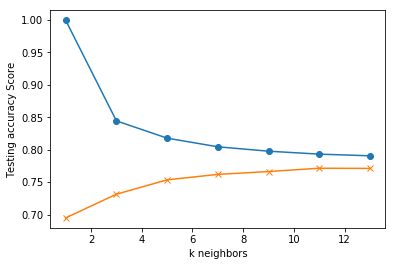

In [47]:
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt

# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 14, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 14, 2), train_scores, marker='o')
plt.plot(range(1, 14, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [48]:
# Note that k: 7 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print('k=7 Test Acc: %.3f' % knn.score(X_test, y_test))

k=7 Test Acc: 0.762


## 'KNN' Predictions with Real Data

In [59]:
#knn.fit(X_Real, y_Real)
print('k=7 Test Acc: %.3f' % knn.score(X_Real, y_Real))

k=7 Test Acc: 0.800


## Random Forests

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9993333333333333

## 'Random Forest' Predictions with Real Data

In [53]:
rf = rf.fit(X_Real, y_Real)
rf.score(X_Real, y_Real)

1.0

In [45]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf.feature_importances_
importances

array([0.06045178, 0.01186906, 0.0203948 , 0.01396335, 0.06688112,
       0.09723982, 0.04170824, 0.02874547, 0.02464704, 0.0210998 ,
       0.01815081, 0.06116561, 0.05425749, 0.05159007, 0.05064599,
       0.04949204, 0.04958521, 0.05107828, 0.04713789, 0.04624281,
       0.04339016, 0.04371523, 0.04654796])

## Decision Trees

In [60]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy')

In [61]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [67]:
predictions_df = dtree.predict(X_test)

In [68]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve

print('accuracy %s' % accuracy_score(y_test, predictions_df))
cm = confusion_matrix(y_test, predictions_df)
print('confusion matrix\n %s' % cm)

accuracy 0.7334666666666667
confusion matrix
 [[4833 1008]
 [ 991  668]]


## 'Decision Trees' Predictions with Real Data

In [71]:
dtree.fit(X_Real, y_Real)
predictions_df_Real = dtree.predict(X_Real)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve

print('accuracy %s' % accuracy_score(y_Real, predictions_df_Real))
cm = confusion_matrix(y_Real, predictions_df_Real)
print('confusion matrix\n %s' % cm)

accuracy 1.0
confusion matrix
 [[16  0]
 [ 0  4]]
